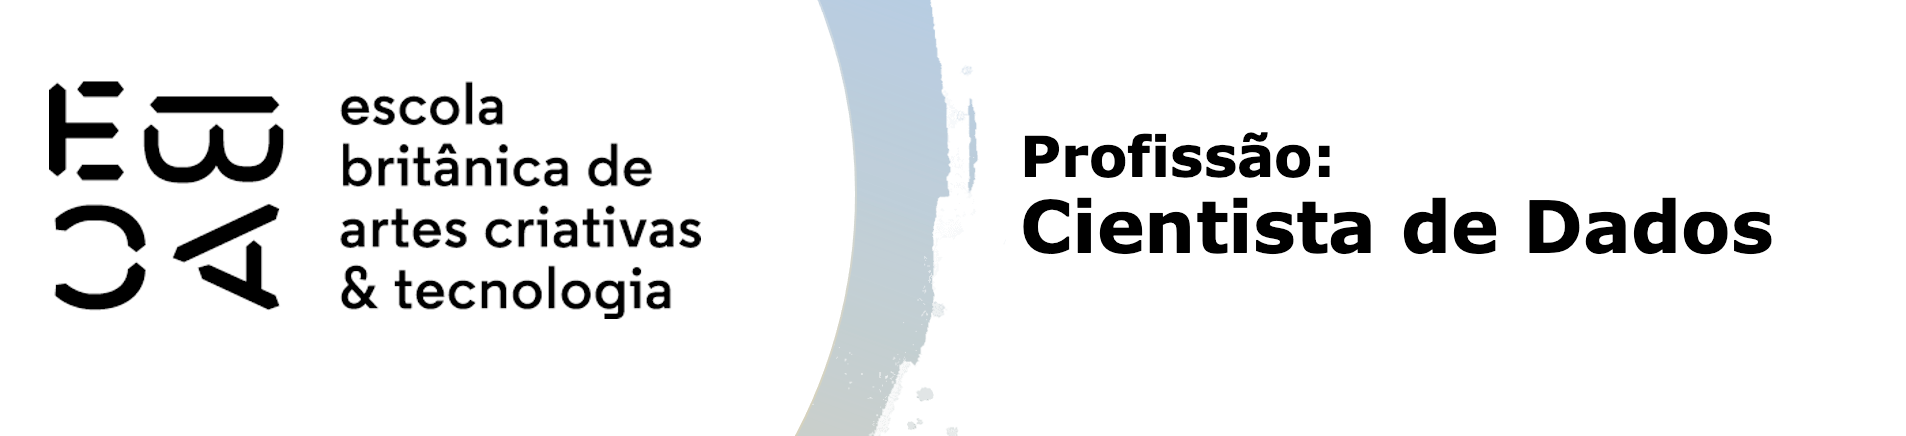

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

**Verificando valores missing**

In [22]:
# separando o nome das variáveis de interesse

quantidades = [
    'Administrative',
    'Informational',
    'ProductRelated',
]

duracao = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
]

variaveis = list(np.sort(quantidades + duracao))

In [9]:
df[variaveis].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 578.1 KB


<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Podemos verificar que não há valores missing entre as variáveis de interesse
    
</div>

**Verificando a distribuição dessas variáveis**

In [10]:
# função para criar e retornar um DataFrame por tipo de página
# com a informação de quantidade e duração organizada em linhas e não por colunas

def criar_pagina_df(nome):
    nome_coluna_duracao = f'{nome}_Duration'
    d = df[[nome, nome_coluna_duracao]].copy()
    d.rename(columns={nome: 'quantidade', nome_coluna_duracao: 'duracao'}, inplace=True)
    d['pagina'] = nome
    return d

In [11]:
# exemplo:
criar_pagina_df('ProductRelated').head()

,quantidade,duracao,pagina
0,1,0.000000,ProductRelated
1,2,64.000000,ProductRelated
2,1,0.000000,ProductRelated
3,2,2.666667,ProductRelated
4,10,627.500000,ProductRelated


In [12]:
# cria um novo DataFrame com as informações dos tipos de páginas organizadas em linhas e não por colunas

product = criar_pagina_df('ProductRelated')
informational = criar_pagina_df('Informational')
administrative = criar_pagina_df('Administrative')
df_paginas = pd.concat([administrative, informational, product])

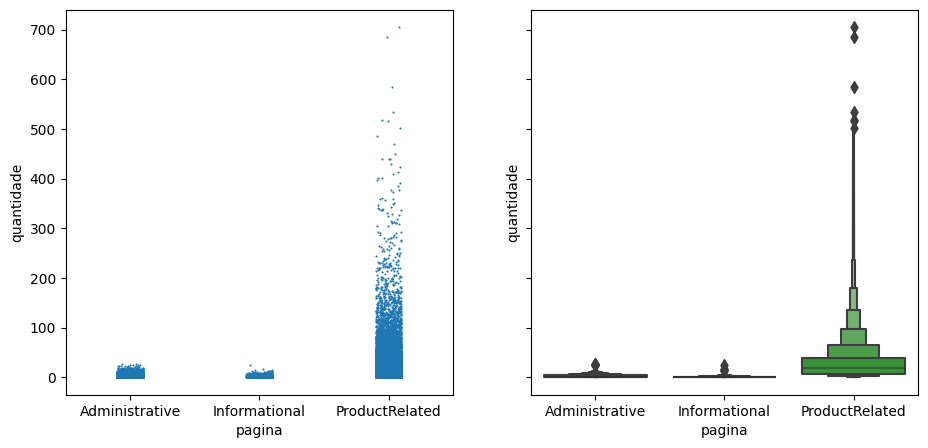

In [13]:
fig, ax = plt.subplots(1, 2, sharey='all', figsize=(11, 5))
sns.stripplot(data=df_paginas, y='quantidade', x='pagina', ax=ax[0], s=1.5)
sns.boxenplot(data=df_paginas, y='quantidade', x='pagina', ax=ax[1])
plt.show()

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

O gráfico acima exibe a relação entre a quantidade de acessos por usuário em cada tipo de página. Podemos verificar que a maior parte dos usuários acessa a página de produtos, com a maioria dos casos com até 200 acessos por usuário. 
    
</div>

In [14]:
df_paginas[['pagina', 'duracao']].groupby('pagina').agg(['mean', 'median', 'std', 'min', 'max'])

duracao                                           
                       mean      median          std  min          max
pagina                                                                
Administrative    80.818611    7.500000   176.779107  0.0   3398.75000
Informational     34.472398    0.000000   140.749294  0.0   2549.37500
ProductRelated  1194.746220  598.936905  1913.669288  0.0  63973.52223

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Na tabela acima temos a média, mediana, o desvio padrão, o mínimo e máximo referente ao tempo de acesso a cada tipo de página. Observando a média e mediana, verificamos que os usuários permanecem na página de produtos por mais tempo. 
    
</div>

**Padronização dos valores das variáveis**

A escala de medida das variáveis pode ter um impacto bastante relevante no resultado de um agrupamento, o que pode ter um efeito arbitrário, sem controle e levar a resultados ruins. Vamos padronizar todas as variáveis para que fiquem com média 0 e variância 1, de modo a mitigar esse efeito.

In [15]:
X_pad = pd.DataFrame(StandardScaler().fit_transform(df[variaveis]), columns = variaveis)
X_pad.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430


## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

**Método do cotovelo**

In [16]:
SQD = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, n_init='auto', random_state=1)
    km = km.fit(X_pad)
    SQD.append(km.inertia_)

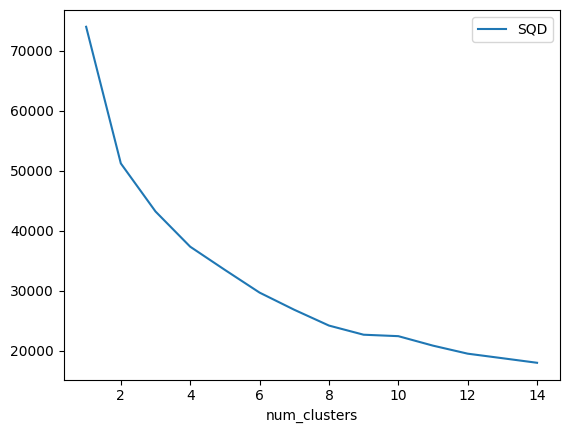

In [17]:
df_sqd = pd.DataFrame({'num_clusters': list(range(1, len(SQD)+1)), 'SQD': SQD})
df_sqd.plot(x = 'num_clusters', y = 'SQD');

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Podemos observar no gráfico acima que pelo método do cotovelo temos 2 grupos
    
</div>

**Coeficiente de Silueta**

In [18]:
siluetas = []
max_clusters = 10

for n_clusters in range(2, max_clusters+1):
    km = KMeans(n_clusters=n_clusters, n_init='auto', random_state=1).fit(X_pad[variaveis])
    siluetas.append(silhouette_score(X_pad[variaveis], km.labels_))
    nomes_grupos = [f'grupo_{g}' for g in range(n_clusters)]
    X_pad[f'cluster_{n_clusters}'] = pd.Categorical.from_codes(km.labels_, categories = nomes_grupos)

In [19]:
X_pad.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0,grupo_0


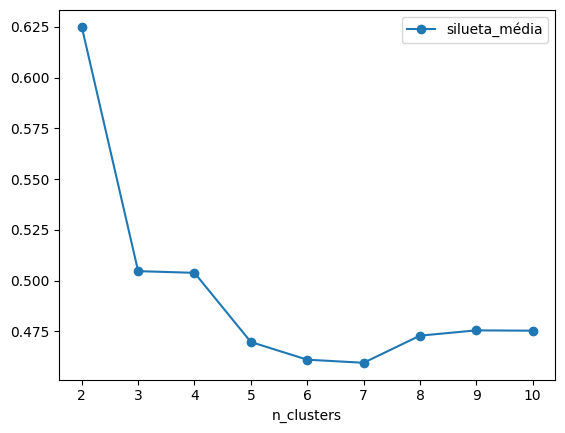

In [20]:
df_silueta = pd.DataFrame({'n_clusters': list(range(2, max_clusters+1)), 'silueta_média': siluetas})
_ = df_silueta.plot.line(x = 'n_clusters', y = 'silueta_média', marker='o')

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Pelo método da silueta, podemos ver claramente que temos 3 grupos na base de dados.
    
</div>

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

**Análise descritiva para 2 grupos**

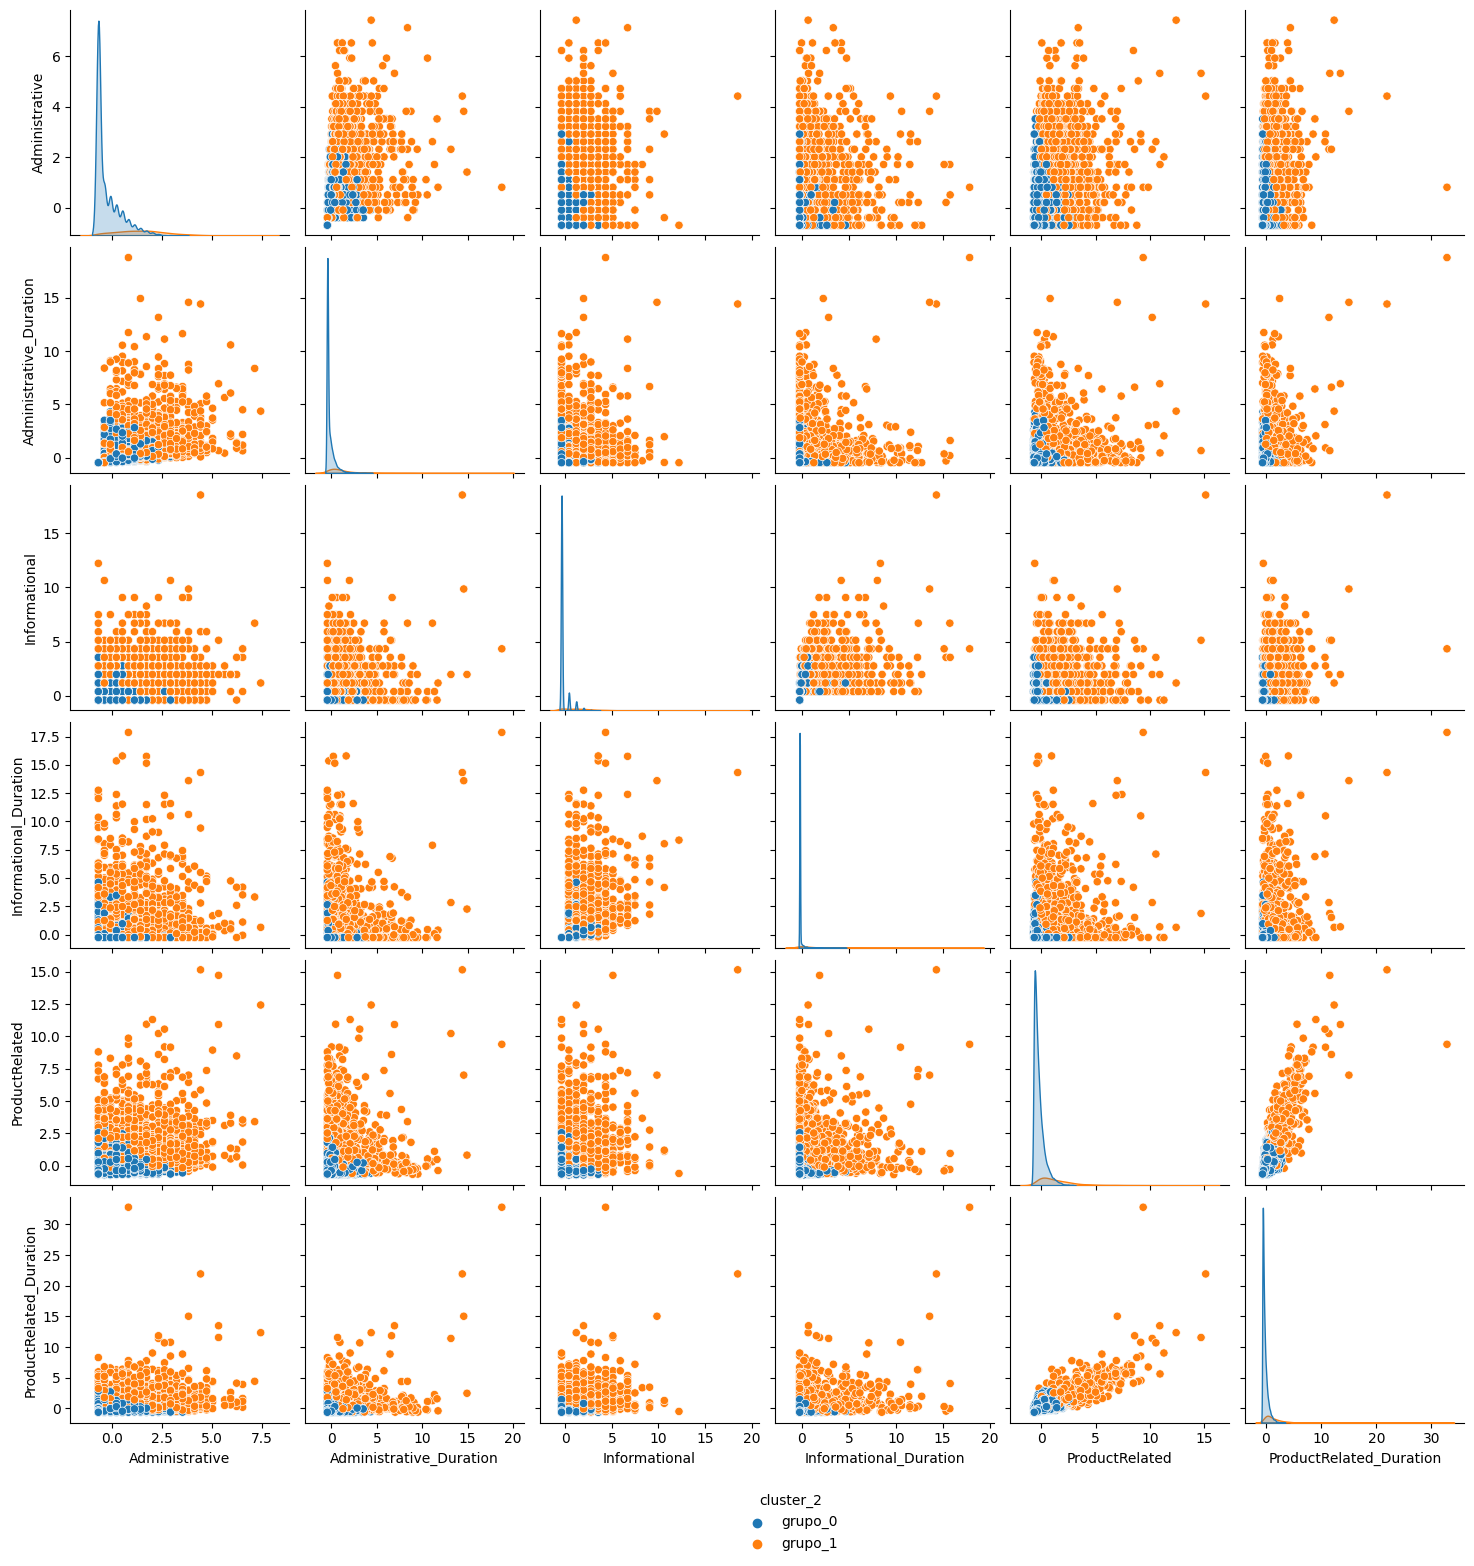

In [42]:
g = sns.pairplot(X_pad[variaveis + ['cluster_2']], hue='cluster_2')
sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, -0.050))

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Podemos ver no gráfico acima a separação distinta de 2 grupos. Essa separação pode ser bem observada no gráfico Administrative X Informational, destacado como grupo_0, azul. Esse grupo representa os usuários que acessam essas 2 páginas enquanto o grupo_1 representa os usuários que acessam a página de produtos.
    
</div>

**Análise descritiva para 3 grupos**

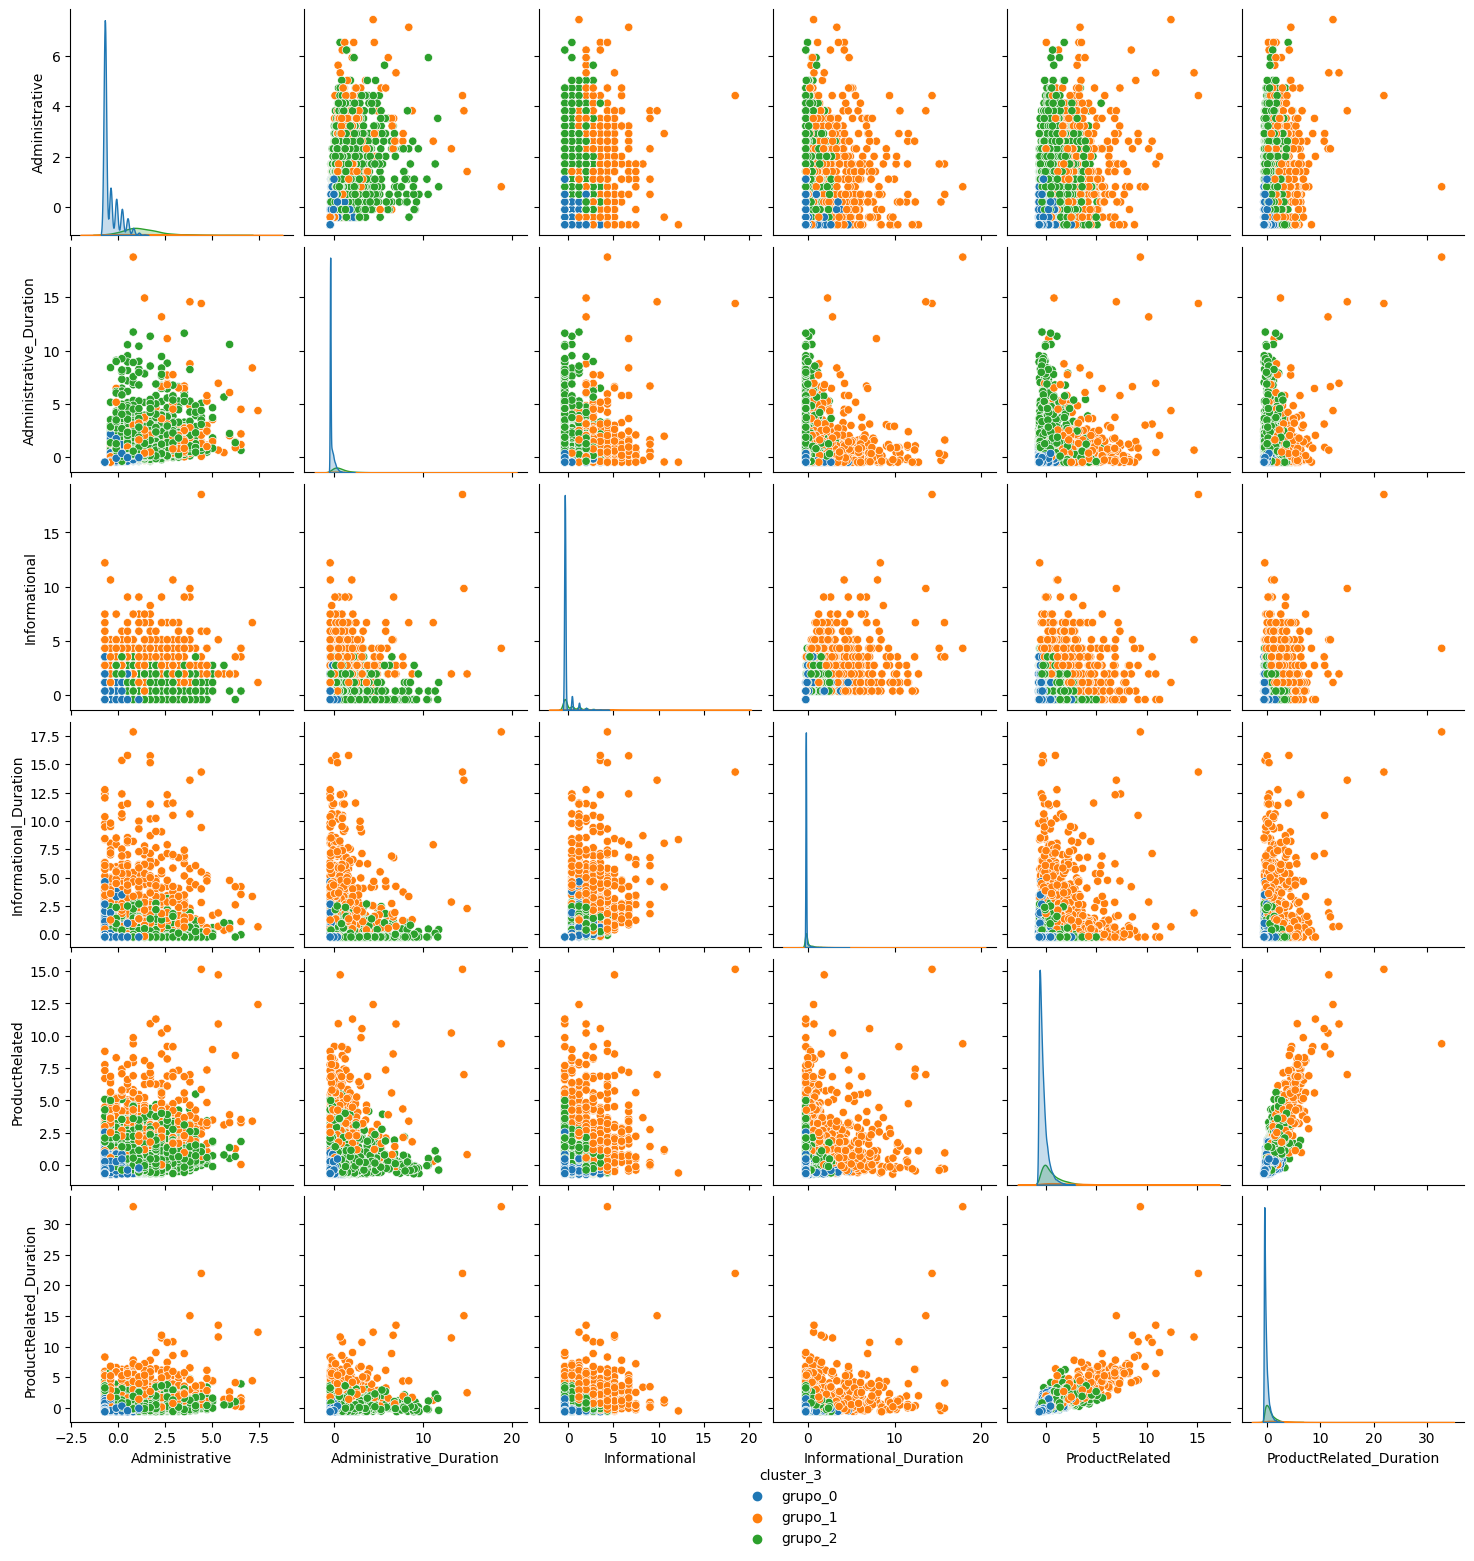

In [41]:
g = sns.pairplot(X_pad[variaveis + ['cluster_3']], hue='cluster_3')
sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, -0.050))

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Podemos ver no gráfico acima a separação de 3 grupos, porém precisamos de mais detalhes para classificar os grupos entre os tipos de página.
    
Para determinar os grupos que classificados, vamos adotar como critério a quantidade e o tempo de acesso a cada página.
    
</div>

In [43]:
# adicionando uma coluna do DataFrame principal com o grupo gerado

df['grupo'] = X_pad['cluster_3']

In [48]:
# aqui realizamos a soma total da quantidade de acessos em cada página por grupo
qtd = df[quantidades + ['grupo']].groupby('grupo').sum(); qtd

,Administrative,Informational,ProductRelated
grupo,,,
grupo_0,8438,1488,175660
grupo_1,4002,2317,78462
grupo_2,16106,2404,137127


In [55]:
# para cada página, exibimos o nome do grupo com a maior quantidade de acessos.
qtd.idxmax()

Administrative    grupo_2
Informational     grupo_2
ProductRelated    grupo_0
dtype: object

In [56]:
# aqui realizamos a soma total do tempo de acesso em cada página por grupo
tempo = df[duracao + ['grupo']].groupby('grupo').sum(); tempo

,Administrative_Duration,Informational_Duration,ProductRelated_Duration
grupo,,,
grupo_0,225639.154927,60704.765476,6.404628e+06
grupo_1,151061.161612,259896.671270,3.249537e+06
grupo_2,619793.151412,104443.229703,5.077056e+06


In [58]:
# para cada página, exibimos o nome do grupo com a maior quantidade de tempo
tempo.idxmax()

Administrative_Duration    grupo_2
Informational_Duration     grupo_1
ProductRelated_Duration    grupo_0
dtype: object

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Para cada grupo classificado, de acordo com os dados das tabelas acima, podemos concluir que:
    
- **grupo_0**: grupo dos usuários que acessam a página de produtos. Podemos verificar que esse grupo aparece relacionado a página de produto com relação a maior quantidade de acessos e também quanto ao tempo.<br><br>
    
- **grupo_1**: grupo de usuários que acessam a página informativa. Podemos observar que com relação a quantidade de acessos, o grupo_2 é classificado como o grupo de usuários que acessam a página administrativas, porém o grupo_1 possui maior tempo de acesso a página informativa, sendo esse o critério de desempate nesse caso.<br><br> 
    
- **grupo_2**: grupo de usuários que acessam a página administrativa.
    
</div>

**Definindo o nome dos grupos**

In [63]:
df['grupo'] = df['grupo'].map({
    'grupo_0': 'Produtos',
    'grupo_1': 'Informativa',
    'grupo_2': 'Administrativa',
})

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [81]:
# agrupando por grupo é calculando a média, mediana, desvio padrão e valor máximo para BounceRates
# calculando a quantidade de Revenue
df[['grupo', 'BounceRates', 'Revenue']].groupby('grupo').agg({
    'BounceRates' : ('mean', 'median', 'std', 'max'), 
    'Revenue' : 'count'
})

BounceRates                               Revenue
                      mean    median       std       max   count
grupo                                                           
Produtos          0.027302  0.002083  0.054625  0.200000    9294
Informativa       0.006750  0.004545  0.007757  0.066667     567
Administrativa    0.006500  0.003333  0.009816  0.161905    2469

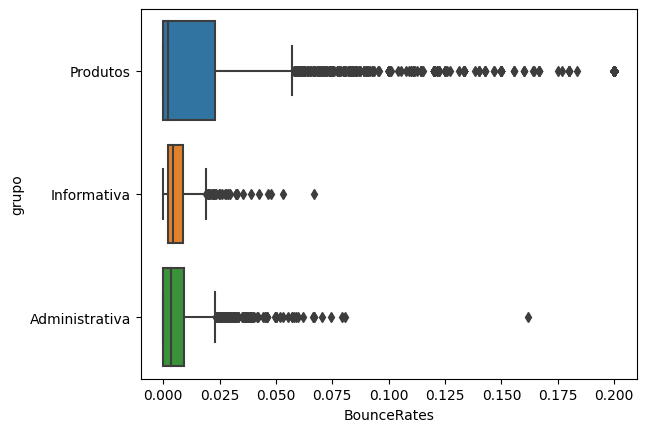

In [84]:
_ = sns.boxplot(data=df[['grupo', 'BounceRates', 'Revenue']], x="BounceRates", y="grupo")

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Analisando a mediana da taxa de rejeição (BounceRates) e a quantidade de compras para cada grupo, podemos concluir que o grupo de clientes mais propensos a compra é o grupo de "Produtos". Esse é o grupo com a maior quantidade de compra e a mediana da taxa de rejeição está próxima de zero além de ser a menor entre os grupos.
    
</div>